# CM50268 :: Coursework Part 1 :: Bayesian Linear Regression

**Total Marks 15 (15% of overall unit grade).**

*Submission deadline: 8pm, March 22th, 2024. Please submit this file and the Part 2 file together in Moodle*

## Submission & Marking

For this coursework there are a number of places where you are expected to enter your own code. Every place you have to add code is  indicated by:

`#### **** YOUR CODE HERE **** ####`


There is also one place where you are asked to enter explanatory text. Full instructions as to what is expected should be found above all the relevant cells.

**Please submit your completed workbook using Moodle**. The workbook you submit must be an `.ipynb` file, which is saved into the directory you're running Jupyter; alternatively you can download it from the menu above using `File -> Download As -> Notebook (.ipynb)`. Remember to save your work regularly (Save and Checkpoint in the File menu, the icon of a floppy disk, or Ctrl-S); the version you submit should have all code blocks showing the results (if any) of execution below them.

**You should take care to avoid any suggestion of plagiarism in your submission.** There is helpful information on how to avoid plagiarism on the University website: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html


## Automarker Guide

This is an auto-marked coursework. Please carefully follow the instructions to make sure your answer can be recognised by the automarker. 


#### Please follow the following three key points when answering questions：

1. Strictly avoid adding or deleting parameters, as well as modifying the return output of the given function. For example: 

    def compute_posterior(PHI, y, alph, s2):
        #
        #### **** YOUR CODE HERE **** ####
        #
        return Mu, SIGMA 

   In this function, PHI, y, alpha, s2 and Mu,SIGMA should **NOT** be changed. 

2. The notebook includes some test cells to ensure your functions and global variables meet automarking requirements. These test cells will be used to verify whether your code is working as expected. For example:

        try:
            Mu  # computed by the function "compute_posterior"
            w   # computed by the function "fit_pls"
        except Exception as err:
            print('Error:', err)
          
   In this example, Mu,SIGMA = compute_posterior(PHI_train, y_train, alpha, sigma2). The globle variable Mu will be checked.      **Please make sure your code can pass the test cell check before submitting your codes.**
    
3. Make sure your code for creating plots is placed **in a separate cell**. This is important because using matplotlib in the same cell (such as plt.plot or ax.plt) might cause issues in automarking.


## Overview of Part 1 tasks

Coursework Part 1 focuses on implementing some of the requisite calculations and manipulations for applying Bayesian linear regression models covered in Lectures 02 - 05.

Exercises include:

- computing the posterior distribution,
- computing the marginal likelihood,
- evaluating and choosing regularisation parameters,
- obtaining posterior mean models,
- calculating error-bars (the predictive variance), 
- ... some presentation of results.

The data will be derived from a synthetic, noisy, sine wave and our model will be a linearly-weighted set of "Gaussian" (RBF) basis functions. In a change from the lectures, a modification has been made to the data: there are no observations from one particular region of the data space. One of the aims of the lab is to see how this aspect impacts on the uncertainty of the model predictions.

There are 3 principal tasks (detailed below), with varying marks. In summary here:

[Task 1](#task1): Fit various Gaussian RBF-based linear models to the training data using penalised least-squares (OLS), and visualise the results (4 marks) 

[Task 2](#task2): Replicate the example slide attached along with this notebook file using the model and data here  - that is, compute the train, validation and test set errors, plus the marginal likelihood (the red dashed curve in the example slide), over a range of $\lambda$ (or $\alpha$) values (9 marks + 1 bonus mark)

[Task 3](#task3): Identify the best posterior mean model, visualise it along with its error-bars (predictive variance), and consider how those error-bars might be usefully exploited (2 marks + 1 bonus mark)


## Setup

### Support code

To get started, the code cell below imports the requisite standard Python modules, plus a setup module `CM50268_CWP1_Setup` specific to this lab. This module contains:

- the class `DataGenerator` to synthesise all the data sets needed,
- the class `RBFGenerator` to create the necessary Gaussian "RBF" basis matrices for varying data sets,
- the function `error_rms` to simply calculate errors for a given target values $t$ and corresponding model output $y$.

We also set some "constants" below: data set sizes and the generative noise standard deviation, which we fix at $\sigma=0.1$ for the entire exercise.


In [1]:
%matplotlib inline
# Standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# Lab-specific support module
import CM50268_CWP1_Setup as CWP1
#
N_train = 12
N_val   = N_train
N_test  = 250
#
sigma = 0.1
s2    = sigma**2


### Generate Data
We synthesise three data sets:
- training set of size $N_{train}=12$ with added noise $\sigma=0.1$
- validation set of size $N_{val}=12$ with added noise $\sigma=0.1$
- test set of size $N_{test}=250$ with **no noise** and **covers the full state space**

**Note:** we assume $\sigma$ is known and fixed. A feature of the test set is that *it will include data from a region where there is no training data*.

### Generate Basis
For our linear model, we use as many functions as data points (a "complete" basis), comprising $N-1$ equally-spaced Gaussian functions (of width 1), plus a fixed "bias" or "offset". If we call `evaluate` on the basis generator, we get a $N\times{}M$ matrix $\mathbf{\Phi}$ returned, where each column / row contains the output of each basis function on each data point respectively: that is, $\mathbf{\Phi}_{nm} = \phi_m(x_n)$. The use of a bias means the first column contains simply a fixed value of one. 

For the training and validation set, this matrix $\mathbf{\Phi}$ will be $12\times 12$, whereas for the test set it will be $250 \times 12$.

For illustration, the data and the underlying "ground-truth" (sine wave) are shown below, with basis functions overlaid.

<img src="data-and-basis.png" alt="Data and basis" style="width: 500px;"/>


In [2]:
# Data - create generator instance, and synthesise 3 sets
#
generator = CWP1.DataGenerator(noise=sigma)
#
(x_train, y_train) = generator.get_data('TRAIN', N_train)
(x_val, y_val) = generator.get_data('VALIDATION', N_val)
(x_test, y_test) = generator.get_data('TEST', N_test)

# Basis - create generator instance and compute the basis matrices for all 3 data sets
# Note that because we use a "bias" function, we need N-1 Gaussians to make the
# basis "complete" (i.e. for M=N)
#
M = N_train-1
r = 1 # Basis radius or width
centres = np.linspace(generator.xmin, generator.xmax, M)
basis = CWP1.RBFGenerator(centres, width=r, bias=True)
#
PHI_train = basis.evaluate(x_train)
PHI_val = basis.evaluate(x_val)
PHI_test = basis.evaluate(x_test)

## Task 1a <a name="task1"></a>
**(2 marks)**

Write a function `fit_pls` (its signature is defined in the cell below) to fit a linear model with basis matrix `PHI_train` to the training data `y_train` for a given value of regularisation parameter $\lambda$. It should return the weight vector $\mathbf{w}_{PLS}$ that minimises the penalised least squares error.

You may find the functions `np.linalg.lstsq` and/or `np.linalg.inv` applicable.

The ideal solution will treat $\lambda=0$ case differently to $\lambda>0$.


In [3]:
## FIT_PLS
##

def fit_pls(PHI, y, lam):
    #
    #### **** YOUR CODE HERE **** ####
    #
    N = PHI.shape[0] # number of rows = the number of data points
    M = PHI.shape[1] # number of columns = the number of basis functions
    
    if lam == 0: # no regularisation being applied to the model, i.e., ordinary least squares regression problem
        w = np.linalg.lstsq(PHI, y, rcond=None)[0]
    else:
        w = np.linalg.inv((PHI.transpose() @ PHI) + (lam * np.eye(M))) @ PHI.transpose() @ y
    
    return w

## Task 1b
**(2 marks)**

1. Write `approxData_test` function, which uses the approximating function from `fit_pls` to compute the prediction, $y$, of test points `x_test`. 

2. Write a convenient graphing function `plot_regression` that you will need for this and following tasks. It should be capable of being passed suitable arguments to plot on the same axes:

    - the data (*i.e.* `y_train` above),
    - the generating function (*i.e.* the noise-free `y_test` above),
    - some approximating function, or prediction, $y$.

A simple example of output is shown below. 

<img src="regression.png" alt="Data and Predictor" style="width: 500px;"/>

Using `fit_pls` in conjunction with `plot_regression`, add code below to plot three graphs for values of $\lambda$ in \[ 0, 0.01, 10\]. In each graph (appropriately labelled by $\lambda$), show:

1. the training data (`x_train` / `y_train`)
2. the underlying generating function (by plotting `x_test` / `y_test`)
3. your fitted function at points `x_test` (you will need to multiply the relevant $\mathbf{\Phi}$ by $\mathbf{w}_{PLS}$)

You should find that the first $\lambda$ value over-fits, the second is "about right" (but only where there is data!) and the third under-fits.


In [4]:
## PREDICTOR FOR TEST DATA
# 

def approxData_test(PHI_test,PHI_train, y_train,lam):
    #
    #### **** YOUR CODE HERE **** ####
    #
    w = fit_pls(PHI_train, y_train, lam) # compute weight vector
    prediction = PHI_test @ w
    return prediction

## GRAPHING FUNCTION 
#  
def plot_regression(approxData_test, x_train, y_train, x_test, y_test):
    #
    #### **** YOUR CODE HERE **** ####
    #
    
    # training data
    plt.scatter(x_train, y_train, color='blue', label='Training Data')
    
    # test data
    if x_test is not None and y_test is not None:
        plt.plot(x_test, y_test, linestyle='dashed', color='goldenrod', label='Testing Data')

    # predictions data
    if approxData_test is not None:
        plt.plot(x_test, approxData_test, color='red', label='Predictions')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Regression Results')
    plt.legend()
    
    pass

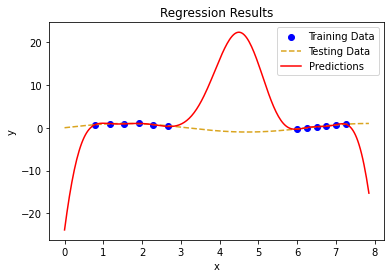

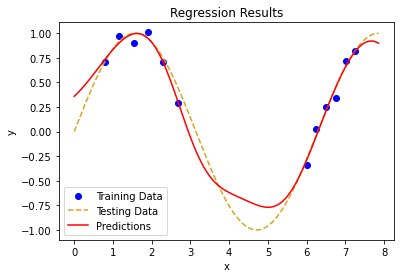

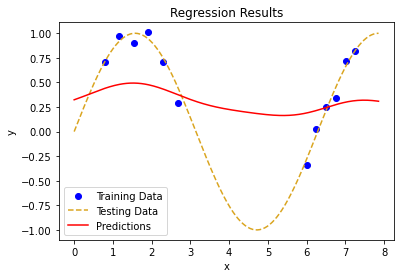

In [5]:
# Add code to plot for lam=0,lam=0.01 and lam=10 case respectively as shown in the example.

#
#### **** YOUR PLOTTING CODE HERE **** ####
#

# Values of lam to plot
lam_values = [0, 0.01, 10]

# Plot for each value of lam
for lam in lam_values:
    # predictions using fit_pls
    predictions = approxData_test(PHI_test, PHI_train, y_train, lam)
    
    # plot  regression results
    plot_regression(predictions, x_train, y_train, x_test, y_test)
    
    plt.show()


## Task 2a <a name="task2"></a>
**(2 marks)**

Write a function `compute_posterior` to compute the posterior mean $\mathbf{\mu}$ and covariance $\mathbf{\Sigma}$ for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$, where $\alpha = \lambda/\sigma^2$ for the equivalence.

Verify the consistency of your posterior code with `fit_pls` by comparing the outputs `w` and `Mu` (they should be the same). As well as defining your function below, append a few lines of code underneath which show your consistency check for $\lambda=0.01$.


In [6]:
## POSTERIOR
##
def compute_posterior(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    
    # number of basis functions
    M = PHI.shape[1]
    
    Mu = np.linalg.inv((PHI.transpose() @ PHI) + (s2 * (alph * np.eye(M)))) @ PHI.transpose() @ y
    SIGMA = s2 * np.linalg.inv((PHI.transpose() @ PHI) + (s2 * (alph * np.eye(M))))
    
    return Mu, SIGMA


# check consistency
#### **** YOUR CODE HERE **** ####
lam = 0.01  # regularization parameter
alph = lam / s2  # hyperparameter alpha
Mu, SIGMA = compute_posterior(PHI_train, y_train, alph, s2)
wPLS = fit_pls(PHI_train, y_train, lam)

print(Mu)
print(wPLS)


# Check whether your variables are defined as required ..
try:
    Mu  # computed by the function "compute_posterior"
    wPLS   # computed by the function "fit_pls"
except Exception as err:
    print('Error:', err)


[[ 0.17542751]
 [-0.00686358]
 [ 0.27718726]
 [ 0.4473822 ]
 [ 0.49475058]
 [-0.47860652]
 [-0.30393321]
 [-0.3891278 ]
 [-0.60869482]
 [-0.02742655]
 [ 0.28990501]
 [ 0.5720677 ]]
[[ 0.17542751]
 [-0.00686358]
 [ 0.27718726]
 [ 0.4473822 ]
 [ 0.49475058]
 [-0.47860652]
 [-0.30393321]
 [-0.3891278 ]
 [-0.60869482]
 [-0.02742655]
 [ 0.28990501]
 [ 0.5720677 ]]


## Task 2b
**(2 marks + 1 bonus mark)**

Write a function `compute_log_marginal` to compute the *logarithm* of the marginal likelihood for the Bayesian linear regression model with basis matrix $\mathbf{\Phi}$ and with hyperparameters $\alpha$ and $\sigma^2$.

In Lecture 04, we have illustrated the equations of finding the most probable hyperparameters to maximise the likelihood with respect to the hyperparameters. The likelihood of the hyperparameters can also be treated as the evidence with respect to $\mathbf{w}$. 

In the CW1 example, the integral form of evidence computation can be rewritten as follows:

$p(\mathbf{y}|\alpha, \sigma^2) = (2 \pi)^{-\frac{N}{2}} |\sigma^2 \mathbf{I} + \alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top}|^{-\frac{1}{2}} \exp\{ -\frac{1}{2} \mathbf{y}^{\top} (\sigma^2 \mathbf{I} + \alpha^{-1} \mathbf{\Phi}\mathbf{\Phi}^{\top})^{-1} \mathbf{y}  \}$

In principle, please use `stats.multivariate_normal.logpdf` for log density computation (don't compute the pdf and then call `np.log`!).

In practice, you should not have numerical issues using `stats.multivariate_normal.logpdf` (this can happen if you experiment with larger data sets, in which case you may wish to look at the `allow_singular` argument.)


#### Woodbury Identity (bonus)

**Bonus**: there is an alternative, and more robust, way of calculating the marginal likelihood directly, which you may wish to explore if you are comfortable with linear algebra and matrix identities. (**1 bonus mark**)  

The "straightforward" way to calculate the marginal likelihood is to compute the NxN covariance matrix and then call the "logpdf" function.  As a result, this will imply an expensive, and potentially numerically troublesome, inversion of an N x N matrix (inside logpdf). This works OK, but in general we can do better.

To gain the extra bonus mark, you would need to re-phrase the straightforward way in terms of the inversion, and determinant, of an M x M matrix. This is computationally a lot cheaper in the usual case where N >> M, and more importantly, numerically much more robust. Slightly confusingly in this exercise here, N = M, so it doesn't appear to make any difference. However, in more general modelling situations, M would be a lot smaller than N, so it would be an important thing to do. In terms of re-phrasing the inversion as M x M, you may wish to look at the "Woodbury Identity" (there is an equivalent for determinants). 



In [7]:
## MARGINAL LIKELIHOOD
##

from scipy import stats

def compute_log_marginal(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    # number of data points
    N = PHI.shape[0]
    
    covariance_matrix = (s2 * np.eye(N)) + ((1 / alph) * np.dot(PHI, PHI.transpose()))
    lgp = stats.multivariate_normal.logpdf(y.T, mean=np.zeros(N), cov=covariance_matrix)
    
    return lgp

def compute_log_marginal_woodbury(PHI, y, alph, s2):    
    
    N = PHI.shape[0]
    M = PHI.shape[1]
    
    # matrices A, U, and V
    A = s2 * np.eye(N)
    U = (1 / alph) * np.eye(M)
    V = np.dot(PHI, PHI.T)
    
    # calculate inverse and determinant using Woodbury identity
    inv_A_UV = np.linalg.inv(A + np.dot(U, V))
    det_A_UV = np.linalg.det(A + np.dot(U, V))
    
    # calculate log marginal likelihood
    log_marginal = -0.5 * N * np.log(2 * np.pi) - 0.5 * np.log(det_A_UV) - 0.5 * np.dot(np.dot(y.T, inv_A_UV), y)
    
    return np.squeeze(log_marginal)


# Task 2c
**(3 marks)**

In the cell below, write some code to replicate below figure for the Gaussian RBF basis and the `y_train` data defined above. 

<img src="Example slide.png" alt="Slide 15 from Lecture 4" style="width: 400px;"/>

In more detail, over a range of $\lambda$ (or equivalent $\alpha=\lambda/\sigma^2$) values, you should:

- Compute the train, validation and test set errors（`err_train`,`err_val`,`err_test`）for the penalised least-squares model (use your `fit_pls` to fit it, and the supplied `error_rms` in 'CM50268_CW1_Setup' to calculate the error). 
- Also compute the *negative* log marginal likelihood (`neglog_evidence`), using the function just written.
- Plot **all these curves on the same graph**, noting that the scale for the errors is different for that of the negative log marginal likelihood.
- In addition to plotting the graph below, add code to compute, and output (using `print`), the *test error* corresponding to the minimum point on: (1) the test error curve itself, (2) the validation curve, (3) the negative marginal likelihood curve.

For easiest interpretation and automarking, please define your $\lambda$ range logarithmically and **fix the range between $-13$ and $5$**. 

First use `np.linspace(begin,end,steps)` to create equally spaced values `v`, then specify `lambda = 10**v`. Please **fix the `steps` value as 100**.

You should find that your graph has a similar qualitative form to the above figure, although the test error curve looks rather "sharp".

**Hints:** 
- You can create a new $y$-axis on the same plot, which shares the $x$-axis, using `plt.gca().twinx()`.
- Remember that $\alpha=\lambda/\sigma^2$. If you don't rescale appropriately, the marginal likelihood curve will not be correctly aligned with the error curves and your minimum point will be incorrect.




In [8]:
#
#### **** YOUR CODE HERE **** ####
#
#Set up plotting spaces

#from CM50268_CWP1_Setup import error_rms

# define lambda values logarithmically
v = np.linspace(-13, 5, 100)
lambda_range = 10**v

# initialise arrays to store errors and negative log marginal likelihood
err_train = np.zeros_like(lambda_range)
err_val = np.zeros_like(lambda_range)
err_test = np.zeros_like(lambda_range)
neglog_evidence = np.zeros_like(lambda_range)

# calculate the error in the train, test and validation sets 
# calculate the negative log marginal-likelihood for a range of lambda

for i, lam in enumerate(lambda_range):
    # fit the model
    w = fit_pls(PHI_train, y_train, lam)
    
    # compute predictions
    y_train_pred = PHI_train @ w
    y_val_pred = PHI_val @ w
    y_test_pred = PHI_test @ w
    
    # compute errors
    err_train[i] = CWP1.error_rms(y_train_pred, y_train)
    err_val[i] = CWP1.error_rms(y_val_pred, y_val)
    err_test[i] = CWP1.error_rms(y_test_pred, y_test)
    
    # compute negative log marginal likelihood
    neglog_evidence[i] = -compute_log_marginal(PHI_train, y_train, lam / s2, s2)
    #neglog_evidence[i] = -np.mean(compute_log_marginal(PHI_train, y_train, lam / s2, s2))

# lambda value corresponding to the minimum errors and negative log marginal likelihood
min_err_test_lambda = lambda_range[np.argmin(err_test)]
min_err_val_lambda = lambda_range[np.argmin(err_val)]
min_neglog_evidence_lambda = lambda_range[np.argmin(neglog_evidence)]

print("Test error corresponding to the minimum point on the test error curve:", np.min(err_test))
print("Test error corresponding to the minimum point on the validation curve:", err_test[np.argmin(err_val)])
print("Test error corresponding to the minimum point on the negative marginal likelihood curve:", err_test[np.argmin(neglog_evidence)])

Test error corresponding to the minimum point on the test error curve: 0.1029411686081703
Test error corresponding to the minimum point on the validation curve: 0.2775818302320925
Test error corresponding to the minimum point on the negative marginal likelihood curve: 0.24567706274810236


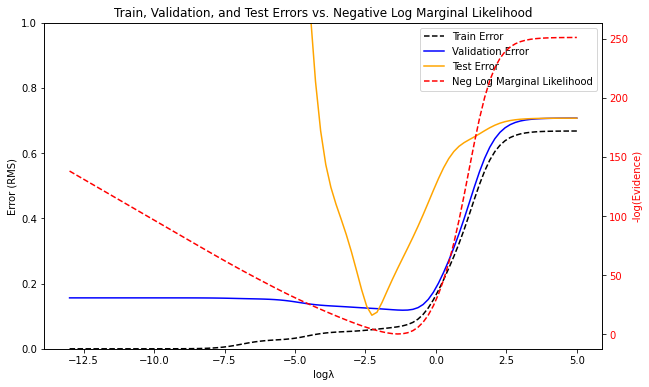

In [9]:
# PRINT THE TEST ERROR
# PLEASE PLOT ALL THE CURVES IN THE SAME FIGURE

# Print the test error corresponds to the minimum point on (1) the test error curve itself,
# (2) the validation curve, and (3) the negative marginal-likelihood curve.
#
#### **** YOUR PLOTTING CODE HERE **** ####
#


fig, ax1 = plt.subplots(figsize=(10, 6))

# errors on primary y-axis
ax1.plot(v, err_train, label='Train Error', color='black', linestyle='--')
ax1.plot(v, err_val, label='Validation Error', color='blue')
ax1.plot(v, err_test, label='Test Error', color='orange')
ax1.set_xlabel('logλ')
ax1.set_ylabel('Error (RMS)', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim([0.0, 1.0])
#ax1.set_xlim([-13.0, 5.0])
#ax1.set_xticks([-12.5, -10.0, -7.5, -5.0, -2.5, 0.0, 2.5, 5.0])

# secondary y-axis for negative log marginal likelihood
ax2 = ax1.twinx()
ax2.plot(v, neglog_evidence, label='Neg Log Marginal Likelihood', color='red', linestyle='--')
ax2.set_ylabel('-log(Evidence)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
#ax2.set_ylim([-2.9, 5])


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Train, Validation, and Test Errors vs. Negative Log Marginal Likelihood')
plt.show()

# Check whether your variables are defined as required  ..
try:
    err_train
    err_val
    err_test
    neglog_evidence
except Exception as err:
    print('Error:', err)

# Task 2d
**(2 marks)**

Find the best value of $\alpha$ according to the marginal likelihood in Task 2c above, call `compute_posterior` to find the posterior mean weight vector `Mu` and use this to compute the posterior mean predictor `y_post`  (*i.e.* $y=\Phi\mu$) at all the test points `x_test`. Then, similar to Task 1b, using your earlier `plot_regression` function, plot on the same axes:
1. the training data (`x_train` / `y_train`),
2. the underlying generating function (by plotting `x_test` and `y_test`),
3. the posterior mean predictor function you just calculated.

You should find that the predictor is a pretty good fit to the underlying generating function *where there was data in the training set*. We can't expect the model to make good predictions in the "gap" where it has not seen any training data (unless it gets lucky!).


In [10]:
# Code to calculate posterior mean predictor 
#### **** YOUR CODE HERE **** ####

# best value of alpha according to the marginal likelihood
lam_value = lambda_range[np.argmin(neglog_evidence)]
best_alpha = lam_value/s2

# posterior mean weight vector Mu using the best alpha
Mu, _ = compute_posterior(PHI_train, y_train, best_alpha, s2)

# posterior mean predictor y_post at all the test points x_test
y_post = PHI_test @ (Mu)


# Check whether your variables are defined as required  ..
try:
    y_post
except Exception as err:
    print('Error:', err)

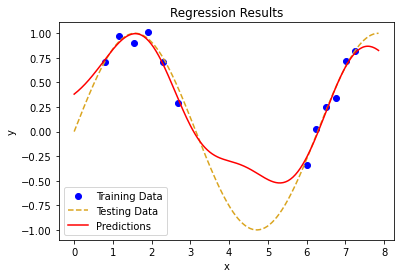

In [11]:
# plot
#### **** YOUR PLOTTING CODE HERE **** ####
#

# Plot the training data, the underlying generating function, and the posterior mean predictor function
plot_regression(y_post, x_train, y_train, x_test, y_test)


# Task 3a <a name="task3"></a>
**(2 mark)**

Repeat the graph above (Task 2d), for the same "best" predictor, but this time also compute the predictive variance matrix `var_matrix` at the points `x_test` and add them to the same plot as "error bars". For plotting the "error bars", you need to calculate the upper and lower bound for the predicted value ( `upper_bound`,`lower_bound`). 

**Notes:**

- By "error bars" we mean the predictive standard deviation, please fix the error bars by +/- one standard deviation,
- To compute the predictive variance at `x_test`, you'll need the matrix `PHI_test`,
- The matplotlib function `plt.fill_between` is a handy utility for plotting error bars,
- If your calculations are correct, you should expect to see larger error bars where there is no data.

In [12]:
#### **** YOUR CODE HERE **** ####
lam_value = lambda_range[np.argmin(neglog_evidence)]
best_alpha = lam_value/s2

MU, SIGMA = compute_posterior(PHI_train, y_train, best_alpha, s2)
# predictive variance matrix var_matrix at the points x_test
var_matrix = s2 + np.dot(np.dot(PHI_test, SIGMA), np.transpose(PHI_test))

# standard deviation as the square root of the diagonal of var_matrix
std_dev = np.sqrt(np.diag(var_matrix))
mean_pred = np.dot(PHI_test, Mu)

# upper and lower bounds for the predicted value
upper_bound = mean_pred.flatten() + std_dev
lower_bound = mean_pred.flatten() - std_dev

# Check whether your variables are defined as required  ..
try:
    var_matrix
    upper_bound
    lower_bound
except Exception as err:
    print('Error:', err)

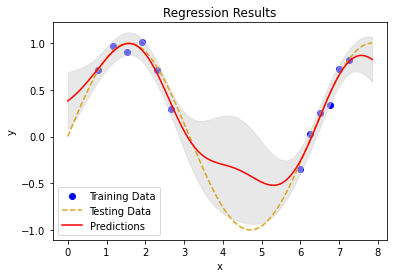

In [13]:
# plot
#### **** YOUR PLOTTING CODE HERE **** ####
#

plot_regression(y_post, x_train, y_train, x_test, y_test)
# plot the error bars using plt.fill_between
plt.fill_between(x_test.flatten(), upper_bound, lower_bound, color='lightgray', alpha=0.5, label='Error Bars')

plt.show()

# Task 3b 
**(1 bonus mark)**

This is a more open-ended question, with an opportunity to think more creatively. (Note that there are only one mark available though.)

Imagine you had built the above model for inclusion within some real-world system where it was desired to make predictions at some arbitrary points $x$ in the future. How might the information from your model's predictive variance be useful in the practical application?

Remember that the predictive model is an $x$-dependent Gaussian distribution over the prediction, and in principle the variance quantifies the likely error (which is a consequence both of the noise on the data and any model uncertainty).

More specifically, your answer might look to address the following questions:

- how could the system exploit the predictive variance to practical advantage on new data?
- what evidence can you supply now (based on the existing test data set) to suggest the approach might work?

In the following box, generate whatever graph(s) you would offer as supporting evidence for the utility of your approach.


In [14]:
import scipy.stats

# Example: Using predictive variance to set confidence intervals for predictions
confidence_levels = [0.2, 0.5, 0.8]  # Desired confidence levels

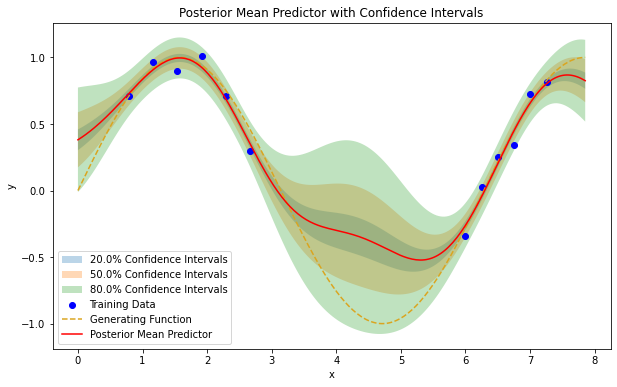

In [15]:
# plot
#### **** YOUR PLOTTING CODE HERE **** ####
#

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plotting predictions with confidence intervals for each confidence level
for confidence_level in confidence_levels:
    # Compute the margin of error based on the predictive variance
    margin_of_error = std_dev * scipy.stats.norm.ppf((1 + confidence_level) / 2)

    # Compute upper and lower bounds for the confidence intervals
    upper_confidence_interval = mean_pred.flatten() + margin_of_error
    lower_confidence_interval = mean_pred.flatten() - margin_of_error

    # Plot confidence intervals
    plt.fill_between(x_test.flatten(), upper_confidence_interval, lower_confidence_interval,
                     alpha=0.3, label=f'{confidence_level*100}% Confidence Intervals')
    
# Plotting predictions, training data, and generating function
plt.scatter(x_train, y_train, color='blue', label='Training Data')
plt.plot(x_test, y_test, linestyle='dashed', color='goldenrod', label='Generating Function')
plt.plot(x_test, y_post.flatten(), color='red', label='Posterior Mean Predictor')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.title('Posterior Mean Predictor with Confidence Intervals')
plt.legend()
plt.show()